## CIS 9660 final project
## XGBoost model

In [1]:
## import packages
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb

import time
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### 1. Import data

In [2]:
## read cleaned data
cardio_xgb = pd.read_csv('https://raw.githubusercontent.com/smeng0428/CIS9660/main/Final%20project/cardio_updated.csv')

In [3]:
cardio_xgb.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi
0,18393,0,168,62.00000,110,80,1,1,0,0,1,0,50,21.96712
1,20228,1,156,85.00000,140,90,3,1,0,0,1,1,55,34.92768
2,18857,1,165,64.00000,130,70,3,1,0,0,0,1,51,23.50781
3,17623,0,169,82.00000,150,100,1,1,0,0,1,1,48,28.71048
4,17474,1,156,56.00000,100,60,1,1,0,0,0,0,47,23.01118


In [4]:
##split the data to 0.7/0.3 ratio
train_set, val_set = train_test_split(cardio_xgb, train_size = 0.7, random_state = 9660)

In [5]:
## split the label and predictors, drop year_age as it is the same as age
train_y = train_set.cardio
train_x = train_set.drop(['age_year', 'cardio'], axis =1)
val_y = val_set.cardio
val_x = val_set.drop(['age_year', 'cardio'], axis =1)

In [6]:
params = {
    'max_depth' : range(2,8),
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
    'colsample_bynode' : [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
    'n_estimators' : range(100, 400, 50),
    'gamma' : range(0,25, 5),
    'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'lambda' : [0.1, 0.25, 0.5, 0.75, 1]
}

In [7]:
start = time.time()
xgb1 = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'), params, 
                         n_jobs=4, scoring = 'roc_auc', n_iter = 300, random_state = 9660)
xgb1.fit(train_x, train_y)
end = time.time()

In [8]:
print('the running time for xgboost modelis '+str(end-start))

the running time for xgboost modelis 4147.976882696152


In [9]:
##def a function for logistic model evaluation.
def tree_eva(x,y,model,train_val):
    name = str(train_val)+"_"
    yhat = model.predict(x)
    prob = model.predict_proba(x)
    accuracy = metrics.accuracy_score(y, yhat)
    precision = metrics.precision_score(y, yhat)
    recall = metrics.recall_score(y, yhat)
    fpr, tpr, threshold = metrics.roc_curve(y, prob[:,1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    f1 = metrics.f1_score(y, yhat)
    value_list = [accuracy, precision, recall, auc, f1]
    name_list = ['accuracy','precision','recall','auc', 'F1_score']
    df = pd.DataFrame(zip(name_list, value_list), columns=['metric','value'])
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
    plt.title(str(train_val)+" set ROC")
    plt.show()
    return df

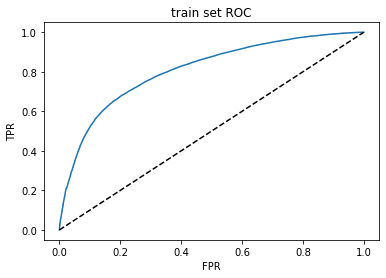

,metric,value
0,accuracy,0.73860
1,precision,0.76226
2,recall,0.68238
3,auc,0.80782
4,F1_score,0.72011


In [10]:
## evaluation for training set
xgb1_train_df = tree_eva(x = train_x, y = train_y, model = xgb1, train_val ='train')
xgb1_train_df

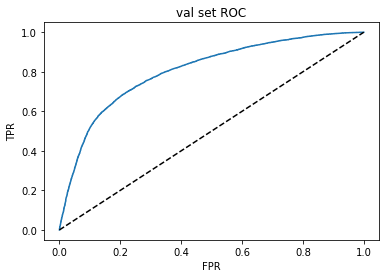

,metric,value
0,accuracy,0.74023
1,precision,0.75451
2,recall,0.68154
3,auc,0.80543
4,F1_score,0.71617


In [11]:
##evaluation for test set
xgb1_test_df = tree_eva(x = val_x, y = val_y, model = xgb1, train_val = 'val')
xgb1_test_df

In [12]:
## optimal paramenters for xgboost model
xgb1.best_params_

{'subsample': 0.8,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.05,
 'lambda': 0.75,
 'gamma': 5,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.5}

In [48]:
## feature importance for xbgboost model
xgb1_imp = pd.DataFrame(zip(train_x.columns, xgb1.best_estimator_.feature_importances_), columns= ['feature', 'importance'])
xgb1_imp = xgb1_imp.sort_values('importance', ascending = False).reset_index(drop = True)
xgb1_imp

,feature,importance
0,ap_hi,0.34005
1,ap_lo,0.29973
2,cholesterol,0.12683
3,age,0.06896
4,active,0.03038
5,bmi,0.02563
6,gluc,0.02300
7,weight,0.02270
8,smoke,0.01976
9,alco,0.01699


In [52]:
## define the function for model comparison
def model_selection(x,y,model):
    thresh = np.round(np.arange(0.01,1, 0.01),2).tolist()
    
    p_list =[]
    r_list =[]
    a_list =[]
    f_list =[]
    prob = model.predict_proba(x)    
    for i in thresh:
        yhat = [1 if j >= i else 0 for j in prob[:,1]]
        
        accuracy = metrics.accuracy_score(y, yhat)
        precision = metrics.precision_score(y, yhat)
        recall = metrics.recall_score(y, yhat)
        f1 = metrics.f1_score(y, yhat)
    
        p_list.append(precision)
        r_list.append(recall)
        a_list.append(accuracy)
        f_list.append(f1)

    df = pd.DataFrame(zip(thresh, p_list, r_list, a_list, f_list), 
                      columns=['threshold','precision','recall','accuracy','F1_score'])
    
    return df

In [53]:
## using xgb1 model to find the best F1_score based on training set.
xgb1_metric = model_selection(x = train_x, y = train_y, model = xgb1)
xgb1_metric

C:\Users\xianw_000\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,precision,recall,accuracy,F1_score
0,0.01000,0.49279,1.00000,0.49279,0.66023
1,0.02000,0.49279,1.00000,0.49279,0.66023
2,0.03000,0.49279,1.00000,0.49279,0.66023
3,0.04000,0.49306,1.00000,0.49333,0.66047
4,0.05000,0.49392,1.00000,0.49508,0.66124
...,...,...,...,...,...
94,0.95000,0.00000,0.00000,0.50721,0.00000
95,0.96000,0.00000,0.00000,0.50721,0.00000
96,0.97000,0.00000,0.00000,0.50721,0.00000
97,0.98000,0.00000,0.00000,0.50721,0.00000


Text(0.5, 1.0, 'Model Metrics Vs Probability Threshold')

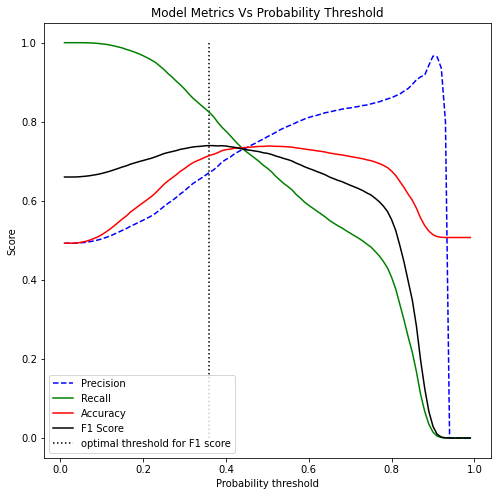

In [59]:
##plot precision/recall/accuracy/f-1
plt.figure(figsize = (8,8))
plt.plot(xgb1_metric.threshold, xgb1_metric.precision, 'b--', label = 'Precision')
plt.plot(xgb1_metric.threshold, xgb1_metric.recall, 'g-', label = 'Recall')
plt.plot(xgb1_metric.threshold, xgb1_metric.accuracy, 'r-', label = 'Accuracy')
plt.plot(xgb1_metric.threshold, xgb1_metric.F1_score, 'black', label = 'F1 Score')
plt.vlines(x = 0.36, ymin = 0, ymax = 1, label = 'optimal threshold for F1 score', linestyles = 'dotted')
plt.xlabel('Probability threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title("Model Metrics Vs Probability Threshold")

In [58]:
## the optimal threshold based on F1_score is 0.36
xgb1_metric.iloc[xgb1_metric.F1_score.idxmax()]

threshold   0.36000
precision   0.67157
recall      0.82342
accuracy    0.71454
F1_score    0.73978
Name: 35, dtype: float64

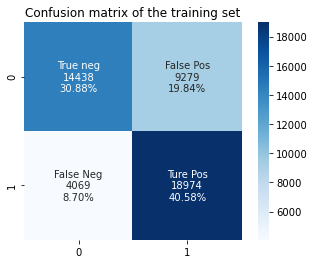

In [46]:
## confusion matrix for the training set when proba threshold is 0.36
train_yhat = [1 if i >= 0.36 else 0 for i in xgb1.predict_proba(train_x)[:,1]]
train_confusion_matrix = metrics.confusion_matrix(train_y, train_yhat)

group_name = ['True neg', 'False Pos', 'False Neg', 'Ture Pos']
group_cnt = ['{0:0.0f}'.format(value) for value in train_confusion_matrix.flatten()]
group_pct = ['{0:.2%}'.format(value) for value in train_confusion_matrix.flatten()/np.sum(train_confusion_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_name, group_cnt, group_pct)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(train_confusion_matrix, annot = labels, square = True,
            fmt = '', cmap = 'Blues').set_title('Confusion matrix of the training set')
plt.show()

In [18]:
## calculate metrics for the val set
val_prob = xgb1.predict_proba (val_x)
val_yhat = [1 if i >= 0.36 else 0 for i in val_prob[:,1]]
val_accuracy = metrics.accuracy_score(val_y, val_yhat)
val_precision = metrics.precision_score(val_y, val_yhat)
val_recall = metrics.recall_score(val_y, val_yhat)
val_f1 = metrics.f1_score(val_y, val_yhat)
xgb1_val_metric= pd.DataFrame({'treshold':[0.36], 'precision':[val_precision], 'recall':[val_recall], 'accuracy':[val_accuracy], 'F1_score':[val_f1]}
                              )
xgb1_val_metric

treshold    0.36000
precision   0.66493
recall      0.81893
accuracy    0.71449
F1_score    0.73393
Name: 0, dtype: float64

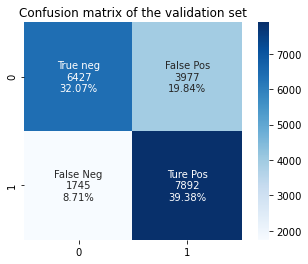

In [45]:
## confusion matrix for the validation set when proba threshold is 0.36
val_confusion_matrix = metrics.confusion_matrix(val_y, val_yhat)

val_group_cnt = ['{0:0.0f}'.format(value) for value in val_confusion_matrix.flatten()]
val_group_pct = ['{0:.2%}'.format(value) for value in val_confusion_matrix.flatten()/np.sum(val_confusion_matrix)]

val_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_name, val_group_cnt, val_group_pct)]
val_labels = np.asarray(val_labels).reshape(2,2)

sns.heatmap(val_confusion_matrix, annot = val_labels, square = True,
            fmt = '', cmap = "Blues").set_title('Confusion matrix of the validation set')
plt.show()

### The optimal threshold of probability based on F-1 score is 0.36. The best F-1 score is 0.73978 for the training set and 0.73393 for the validation set.